In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-12-09 16:04:15.538002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-09 16:04:15.538159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)
  input_mask -= 1
  return input_image, input_mask

In [4]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))
  
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image)
test_images = dataset['test'].map(load_image)

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [6]:
def get_model(img_size, num_classes):
  inputs = tf.keras.Input(shape = img_size + (3,))
  x = tf.keras.layers.Rescaling(1./255)(inputs)
  x = tf.keras.layers.Conv2D(64, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2D(128, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2D(256, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = "leaky_relu", padding = "same")(x)

  x = tf.keras.layers.Conv2DTranspose(256, 3, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2DTranspose(256, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2DTranspose(128, 3, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2DTranspose(128, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2DTranspose(64, 3, activation = "leaky_relu", padding = "same")(x)
  x = tf.keras.layers.Conv2DTranspose(256, 3, strides = 2, activation = "leaky_relu", padding = "same")(x)

  outputs = tf.keras.layers.Conv2D(num_classes, 3, padding = "same", activation = "softmax")(x)
  model = tf.keras.Model(inputs,outputs)
  return model

In [7]:
model = get_model(img_size = (256,256), num_classes = 3)
model.summary()
model.compile(optimizer ="rmsprop",
              loss = "sparse_categorical_crossentropy")
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168

In [57]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/5
460/460 [==============================] - 172s 373ms/step - loss: 0.2381 - val_loss: 0.4504
Epoch 2/5
460/460 [==============================] - 171s 371ms/step - loss: 0.2303 - val_loss: 0.4361
Epoch 3/5
460/460 [==============================] - 171s 372ms/step - loss: 0.2269 - val_loss: 0.4436
Epoch 4/5
460/460 [==============================] - 171s 372ms/step - loss: 0.2196 - val_loss: 0.4479
Epoch 5/5
460/460 [==============================] - 170s 371ms/step - loss: 0.2137 - val_loss: 0.4880


In [53]:
model.save_weights("segment_weights_val_loss_0.3828.hdf5")

In [9]:
model.load_weights("segment_weights_val_loss_0.3773.hdf5")

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

2022-12-09 16:04:56.586465: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


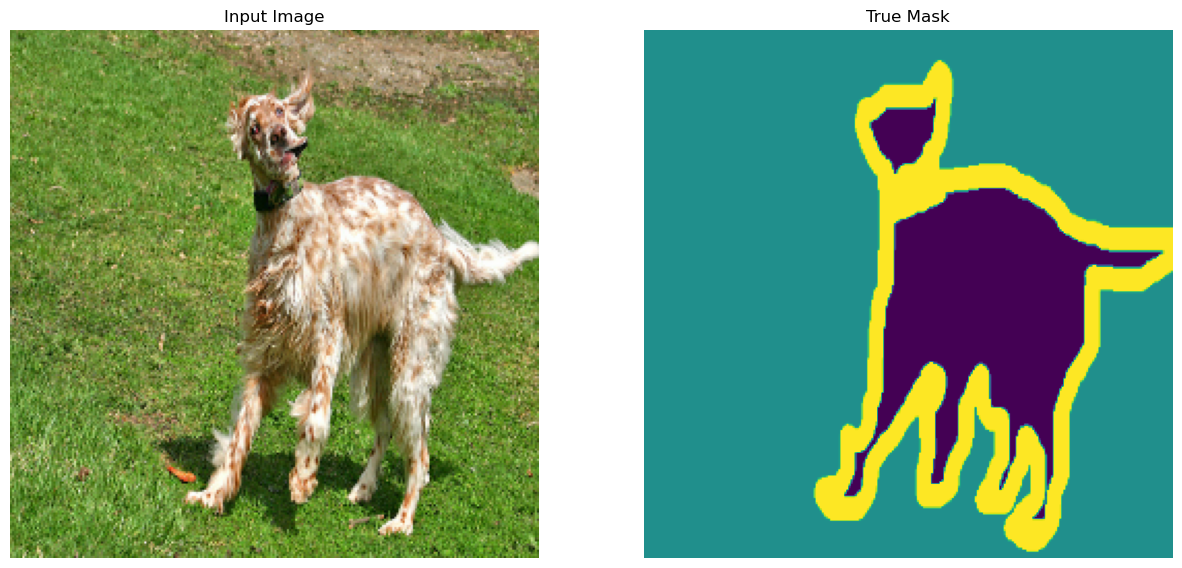

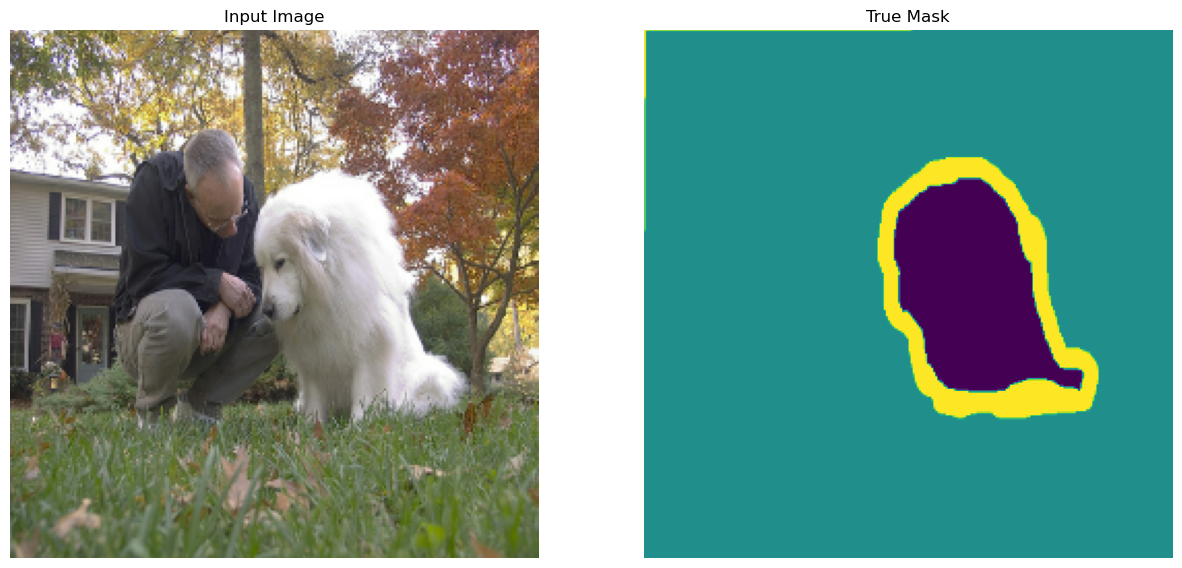

2022-12-09 16:04:57.421135: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [13]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 181ms/step


2022-12-09 16:05:03.992917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


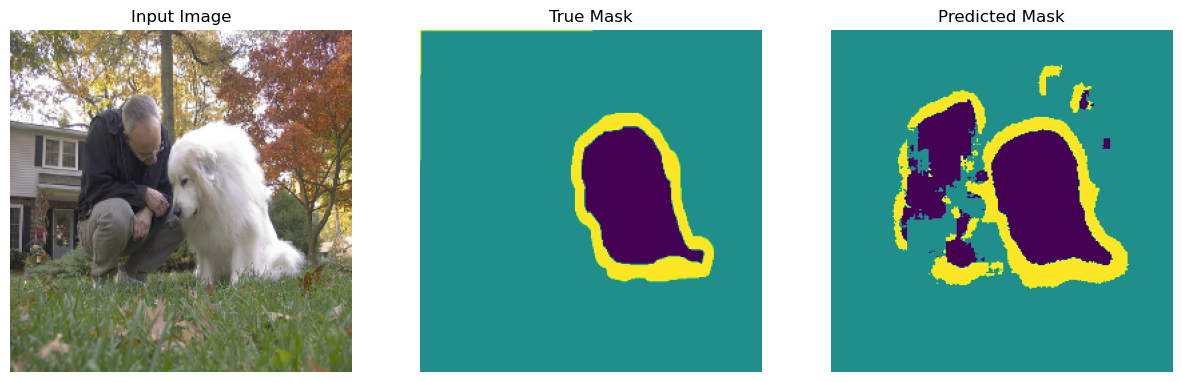

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
show_predictions()

1/1 [==============================] - 0s 16ms/step


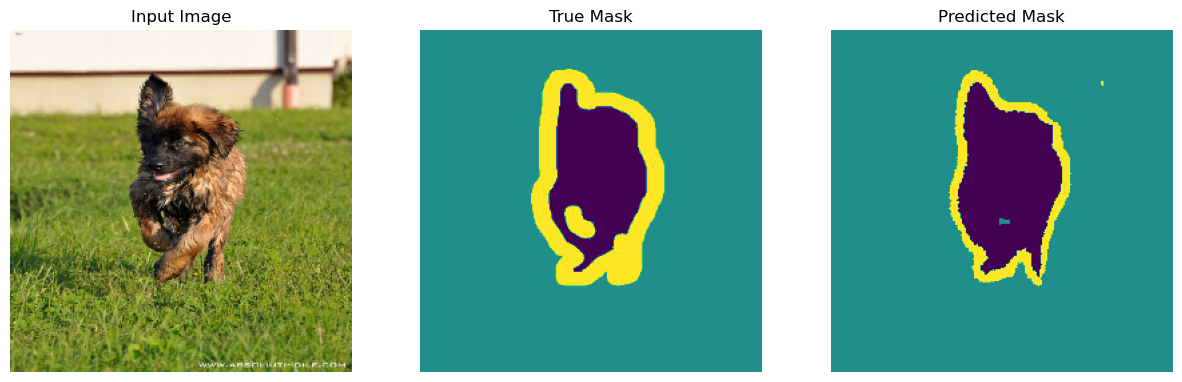

1/1 [==============================] - 0s 16ms/step


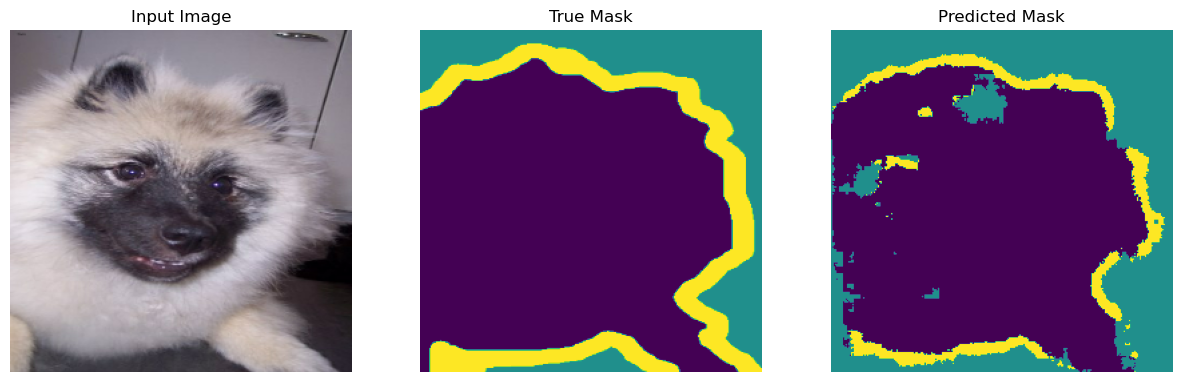

1/1 [==============================] - 0s 17ms/step


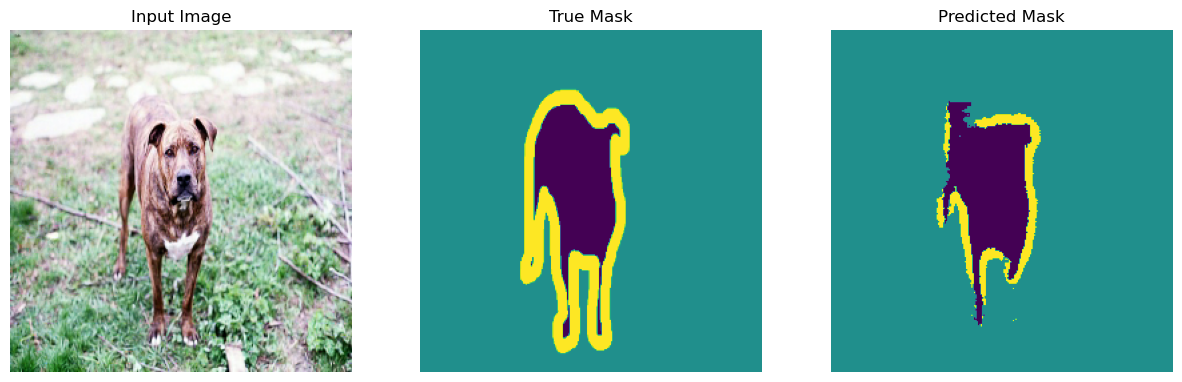

In [56]:
show_predictions(test_batches, 3)